# Darshan-LDMS Integrator
## Performance analysis and diagnosis of parallel I/O applications

Our goal is to close the gap between tracing and diagnosing of I/O applications using LDMS-Darshan integration logs. Darshan-LDMS is a framework that integrates Darshan and LDMS to provide low-latency monitoring of I/O event data during runtime. Absolute timestamps can be used to diagnose these bottlenecks by correlating the I/O logs with other system monitoring logs - deeper dive into the source of the problem.

![static analysis post collecting data](static_analysis.png)


### Example of input file paths:

All LDMS-Darshan CSV files in [this directory](https://github.com/anaveroneze/ldms-darshan-analysis/tree/main/ior/eclipse/darshan-ldms-output/csv/8m-4m) are examples that can be used for analysing with our code. They contain information about individual runs, but users can also input logs about multiple jobs.

### TODOs
- [ ] Visualizations code in R and python
- [ ] Identify app phase:
- [ ] Identify longer operations 
- [ ] Identify long intervals between last read/write and a met operation open/close 
- [ ] Identify distance between the first rank to finish and others
- [ ] Identify long intervals between operations in the same rank

### Load Imbalance Metrics

Reported in a per rank level.

#### **Average/Norm**: 

Measures the mean load per rank.

AVG = Total Load / Number of ranks

#### **Imbalance time** 

Measures the load gain with an ideal load distribution between ranks.

IT = Maximum Load - AVG 

#### **Percent Imbalance**

Measures the performance that could be gained with an ideal load distribution.

PI = [(Maximum Load / AVG) - 1] X 100

#### **Imbalance Percentage** 

Measures the time that the ranks, excluding the slowest one, are not involved in computing.

IP = [(Maximum Load - AVG) / Maximum Load] X [Number of ranks / (Number of ranks - 1)]

In [14]:
import os, csv, time, glob, argparse, psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt 
import rpy2.robjects as ro
import seaborn as sns
from datetime import datetime

class Job:

    def __init__(self, job, ranks, nodes, users, filename, exe):
        
        self.job = job
        self.ranks = ranks
        self.nodes = nodes
        self.users = users
        self.filename = filename
        self.exe = exe

def app_phase(df, output_file, self):
    write_to_file("---------------------------------------")
    write_to_file("EXECUTION SUMMARY PER APPLICATION PHASE:")
    write_to_file("---------------------------------------")

# Calculate and write general statistics in a file
def get_statistics(df, output_file, self):

    with open(output_file, 'w') as f:

        def write_to_file(*args):
            print(" ".join(map(str, args)), file=f, flush=True)

        write_to_file("---------------------------------------")
        write_to_file("JOB CHARACTERISTICS:")
        write_to_file("---------------------------------------")
        write_to_file("Job ID:", self.job)
        write_to_file(len(self.ranks), "Rank (s):", sorted(self.ranks))
        write_to_file(len(self.nodes), "Node (s):", sorted(self.nodes))
        write_to_file("User ID:", self.users)
        write_to_file("Directory:", self.exe)
        write_to_file("Modules collected:", df['module'].unique())
        write_to_file("Module data (MOD):", list(df.type).count('MOD'))
        write_to_file("Meta data (MET):", list(df.type).count('MET'))
        exec_time = round(df['end'].max() - df['start'].min(), 5)
        write_to_file("I/O runtime:", exec_time, "seconds")
        write_to_file("Bandwidth (MiB/second):", round((df['len'].sum() / exec_time) / (1024 ** 2), 2))

        df_rw = df[df['op'].isin(["read", "write"])]
        df_read = df[df['op'] == "read"]
        df = df[df['op'] == "write"]

        write_to_file("---------------------------------------")
        write_to_file("I/O OPERATIONS:")
        write_to_file("---------------------------------------")

        current_op = None
        phase_start = None
        total_durations = {'read': 0, 'write': 0, 'open': 0, 'close': 0}

        def update_total_duration(op, phase_start, phase_end, length):
            if current_op is not None and current_op == op:
                total_durations[op] += (phase_end - phase_start)

        for index, row in df.iterrows():
            if current_op is None or current_op != row['op']:
                update_total_duration(current_op, phase_start, row['end'], row['len'])
                current_op = row['op']
                phase_start = row['start']

        # Get the last phase
        update_total_duration(current_op, phase_start, row['end'], row['len'])

        pivot_df = df.pivot_table(index=None, columns='op', values='len', aggfunc='sum')
        for op, duration in total_durations.items():
            write_to_file(f'Duration {op}s: {round(duration, 4)} seconds')
            if op == "read" or op == "write":
                bytesproc = round((pivot_df[op].max() / (1024 ** 2)) / duration, 4)
                write_to_file("Bandwidth:", bytesproc, "(MiB/second)")

        write_to_file("\nREADS:", round(df_read['len'].sum() / (1024 ** 2)),  "(MiB)")
        write_to_file("Max size per rank:", round(df_read.groupby('rank')['len'].agg('sum').max() / (1024 ** 2)), "MiB")
        write_to_file("Min size per rank:", round(df_read.groupby('rank')['len'].agg('sum').min() / (1024 ** 2)), "MiB")
        write_to_file("Bandwidth (MiB/second):", round((df_read['len'].sum() / (df_read['end'].max() - df_read['start'].min())) / (1024 ** 2), 2))
        
        write_to_file("\nWRITES:", round(df['len'].sum() / (1024 ** 2)), "(MiB)")
        write_to_file("Max size per rank:", round(df.groupby('rank')['len'].agg('sum').max() / (1024 ** 2)), "MiB")
        write_to_file("Min size per rank:", round(df.groupby('rank')['len'].agg('sum').min() / (1024 ** 2)), "MiB")
        write_to_file("Bandwidth (MiB/second):", round((df['len'].sum() / (df['end'].max() - df['start'].min())) / (1024 ** 2),2))

        # IMBALANCE METRICS:
        write_to_file("---------------------------------------")
        write_to_file("LOAD IMBALANCE METRICS:")
        write_to_file("---------------------------------------")
        # Get difference between execution time and time processing I/O per rank
        df_idle = df.groupby('rank')['dur'].sum().reset_index()
        df_idle.columns = ['Rank', 'I/O Time']
        df_idle['Total time - I/O Time'] = exec_time - df_idle['I/O Time']
        df_idle = df_idle.sort_values(by='Total time - I/O Time', ascending=False)

        write_to_file("Total execution time:", exec_time)
        num_ranks = df_idle['I/O Time'].nunique()
        average = df_idle['I/O Time'].sum() / num_ranks
        write_to_file("- Average Load per Rank:", round(average), "seconds")
        it = df_idle['I/O Time'].max() - average
        write_to_file("- Imbalance Time:", round(it, 2), "seconds")
        pi = ((df_idle['I/O Time'].max() / average) - 1) * 100
        write_to_file("- Percent Imbalance:", round(pi, 2), "%")
        ip = (it / df_idle['I/O Time'].max()) * (num_ranks / (num_ranks - 1))
        write_to_file("- Imbalance Percentage:", round(ip, 2), "%")
        std = np.std(df_idle['I/O Time'])
        write_to_file("- Standard deviation", round(std, 2))

        write_to_file("---------------------------------------")
        write_to_file("SUMMARY PER RANK: ")
        write_to_file("---------------------------------------")
        write_to_file("Total time without executing I/O operations:")
        df['start'] = pd.to_datetime(df['start'], unit='s').dt.round('S')
        df['end'] = pd.to_datetime(df['end'], unit='s').dt.round('S')
        write_to_file(df_idle)
    
# Define jobs characteristics
def main(filename, filepath): 

    df = pd.read_csv(filename, engine="pyarrow")

    # Get basic info about each Job:
    local_df = pd.DataFrame()
    for i in df.job_id.unique():
        
        local_df = df[df['job_id'] == i].copy()
        job = Job(i, local_df['rank'].unique(), local_df['ProducerName'].unique(),local_df['uid'].unique(), 
            local_df['file'].unique(), local_df['exe'].unique())

        local_df.loc[:, 'start'] = local_df['timestamp'] - local_df['dur']
        local_df.loc[:, 'end'] = local_df['timestamp']
        
        # Job characteristics and statistics:  
        output_file = filename.replace(".csv", ".txt")
        # get_statistics(local_df, output_file, job)

        # Job visualizations
        get_visualizations_py(local_df, filepath, i)

        # get_visualizations_R(args.input, "./figures/ior/teste.png")

    # if(system):
    #     correlate_system(args.input, args.system)

## Codes for visualizations in Python and R

In [13]:
def plot_load_time_slice(df, filepath, job_id, op_name):

    df = df[df['len']>0 ]
    fig, ax = plt.subplots(1, 1, figsize=(10, 10)) 
    df.loc[:,'timestamp'] = pd.to_datetime(df['timestamp'], unit='s').dt.round('S')
    df.loc[:,'dur'] = pd.to_timedelta(df['dur'], unit='s').dt.round('S')
    df.loc[:,'start'] = df['timestamp'] - df['dur']
    distinct_dates = df['start'].dt.date.unique()
    # df.loc[:,'rank_time'] = df['start'] - min(df['start'])
    df.loc[:,'rank_time'] = pd.cut(df['start'], bins=20)
    df = df.groupby(by=["rank","rank_time"])["len"].sum().reset_index()

    df['rank_time'] = df['rank_time'].apply(lambda x: x.left.strftime('%H:%M:%S'))
    df.loc[:,'len'] = df['len'] / 1024 / 1024
    df = df.pivot(index="rank", columns="rank_time", values="len")

    sns.heatmap(ax=ax, data=df, cmap="mako", cbar_kws={'label': 'MiB processed'})
    ax.set_ylabel("Rank")
    ax.set_xlabel("Timestamp")
    figure_title = ', '.join(map(str, distinct_dates.astype(str)))
    plt.title(f'Op: {op_name} - Dates: {figure_title}')

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    fig.patch.set_facecolor('white')
    print("Saving figure in:", filepath + "fig1" + str(job_id) + "-" + op_name + ".png")
    plt.savefig(filepath + "fig1" + str(job_id) + "-" + op_name + ".png")
    plt.show()
    plt.close()
    plt.clf()

def plot_bandwidth_per_rank(df, filepath, job_id, op_name):

    plt.figure(figsize=(10, 2))
    df_bw = df.groupby('rank').agg(bw=('len', 'sum'))
    df_bw['bw'] = round(df_bw['bw'] / (2 ** 20) / df['dur'].sum(), 2)
    df = pd.merge(df, df_bw, on='rank')

    heatmap_data = df.pivot_table(index='op', columns='rank', values='bw', aggfunc='sum')
    sns.heatmap(heatmap_data, cmap='viridis', fmt=".1f", cbar_kws={'label': 'Bandwidth\n(MiB/seconds)'})

    plt.xlabel('Rank ID')
    plt.ylabel('')
    plt.title('')
    
    plt.savefig(filepath + "fig2" + str(job_id) + "-" + op_name + ".png")
    plt.show()
    plt.clf()
    plt.close()

def get_visualizations_py(df, filepath, job_id):

    #################################################################
    # WRITE OPERATIONS
    #################################################################
    df_op = pd.DataFrame()
    df_op = df[df['op'] == "write"].copy()
    plot_load_time_slice(df_op, filepath, job_id, "write")
    plot_bandwidth_per_rank(df_op, filepath, job_id, "write")
    #################################################################
    # READ OPERATIONS
    #################################################################
    df_op = pd.DataFrame()
    df_op = df[df['op'] == "read"].copy()
    plot_load_time_slice(df_op, filepath, job_id, "read")
    plot_bandwidth_per_rank(df_op, filepath, job_id, "read")
    return 

def get_visualizations_R(filename, filepath):

    r = ro.r
    r.source(filepath + "temporal_vis.R")
    r.plot_temporal(filepath + "teste1.png")
    r.plot_long_temporal(filepath + "teste2.png")
    r.plot_max_temporal(filepath + "teste3.png")
    r.plot_bandwidth_per_rank(filepath + "teste4.png")
    r.plot_duration(filepath + "teste5.png")

    return 

/tmp/ipykernel_87720/2661124793.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'rank_time'] = pd.cut(df['start'], bins=20)


Saving figure in: /home/ana/Documents/2023/ldms-darshan-analysis/figures/ior/fig117901504-write.png


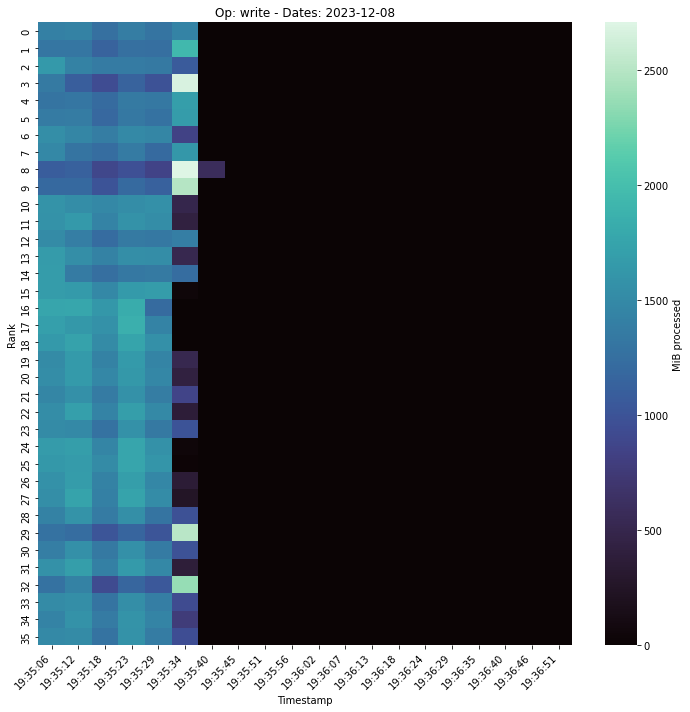

<Figure size 432x288 with 0 Axes>

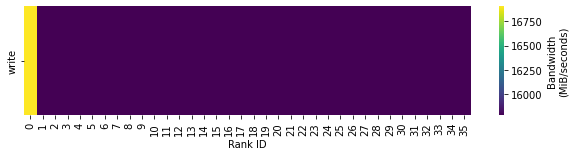

Saving figure in: /home/ana/Documents/2023/ldms-darshan-analysis/figures/ior/fig117901504-read.png


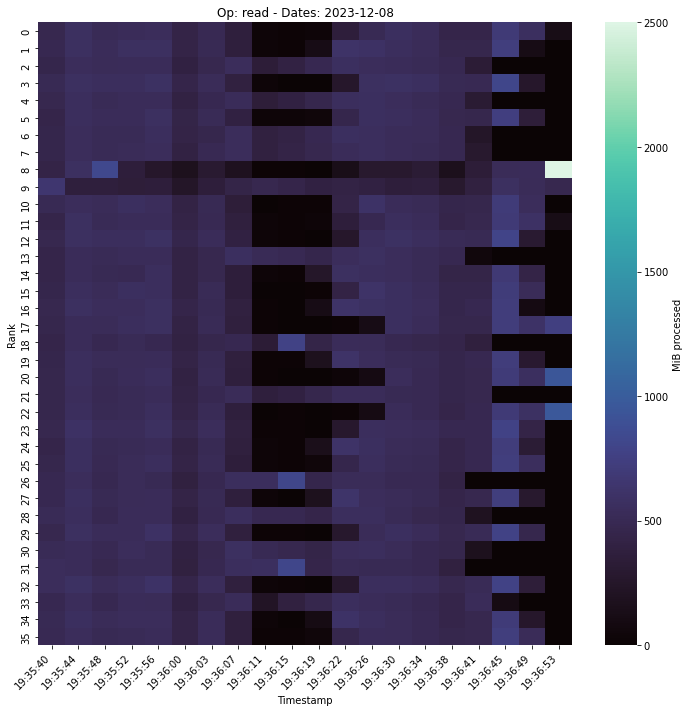

<Figure size 432x288 with 0 Axes>

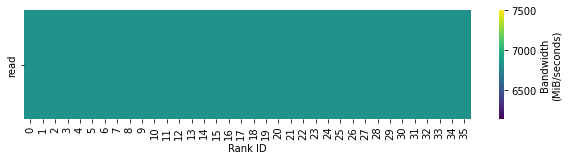

/tmp/ipykernel_87720/2661124793.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'rank_time'] = pd.cut(df['start'], bins=20)


Saving figure in: /home/ana/Documents/2023/ldms-darshan-analysis/figures/ior/fig117893042-write.png


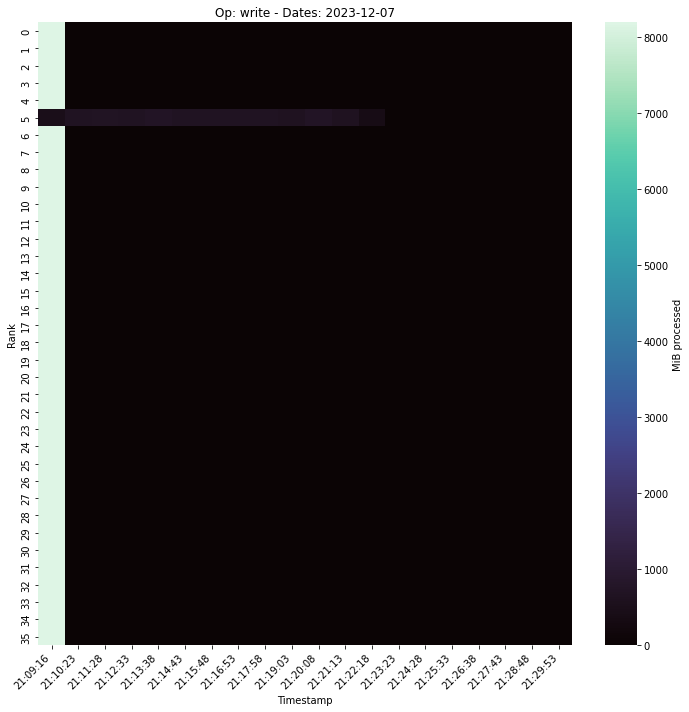

<Figure size 432x288 with 0 Axes>

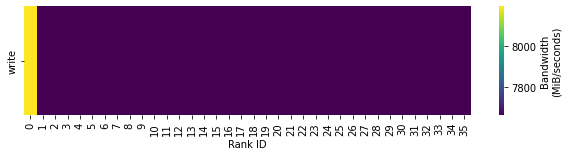

Saving figure in: /home/ana/Documents/2023/ldms-darshan-analysis/figures/ior/fig117893042-read.png


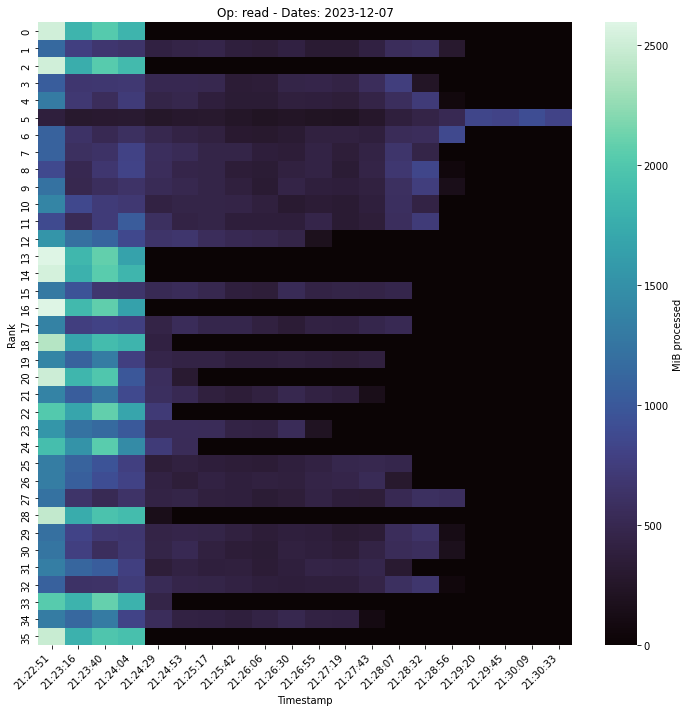

<Figure size 432x288 with 0 Axes>

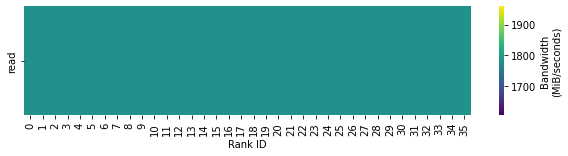

Execution time: 4.3647074699401855 seconds


In [15]:
if __name__ == '__main__':

    start_time_exec = time.time()
    # filename = input('Insert absolut LDMS-Darshan log path:')
    INPUTFILE="/home/ana/Documents/2023/ldms-darshan-analysis/ior/eclipse/darshan-ldms-output/csv/8m-4m/test_all_jobs.csv"
    FILEPATH="/home/ana/Documents/2023/ldms-darshan-analysis/figures/ior/"
    main(INPUTFILE, FILEPATH)   
    end_time_exec = time.time()
    print("Execution time:", end_time_exec - start_time_exec, "seconds")

# Visualizations in R

Load libraries: